# <center><span style='background:yellow'> Réalisez une application de recommandation de contenu</span></center>
# <center><span style='background:yellow'>Algorithmes de filtrage</span></center>

---




## **Sommaire**
1. Chargement et exploration des données
2. Mise en oevre de filtrage basé sur le contenu 
3. Mise en ouvre de filtrage collaboratif (SVD)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## 1. Chargement et exploration des données<a class="anchor" id="1"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [ ]:
data_path = "/content/drive/MyDrive/projet9/data/news-portal-user-interactions-by-globocom/"
figure_path = "/content/drive/MyDrive/projet9/figures/"
saved_data_path = "/content/drive/MyDrive/projet9/data/"

In [ ]:
articles_embeddings = pd.read_pickle(data_path + 'articles_embeddings.pickle')

article_metadata = pd.read_csv(data_path + 'articles_metadata.csv')

merge_user_article = pd.read_csv(saved_data_path + 'merge_user_article.csv')

In [ ]:
merge_user_article.head()

,user_id,click_article_id,n_clicks_user_article,n_clicks_user,session_size_max,n_clicks_by_session_size,n_clicks_by_n_clicks_user,n_clicks_by_n_clicks_user_session_size
0,0,68866,1,8,2,0.5,0.125,0.0625
1,0,87205,1,8,2,0.5,0.125,0.0625
2,0,87224,1,8,2,0.5,0.125,0.0625
3,0,96755,1,8,2,0.5,0.125,0.0625
4,0,157541,1,8,2,0.5,0.125,0.0625


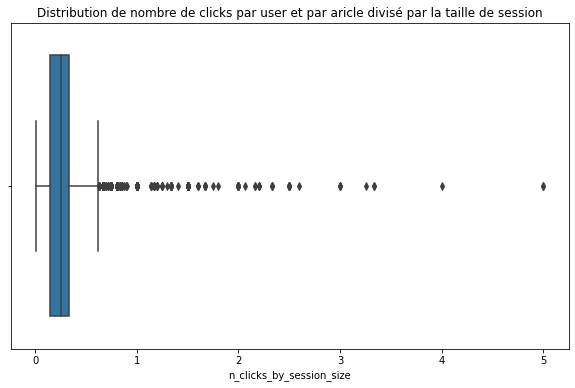

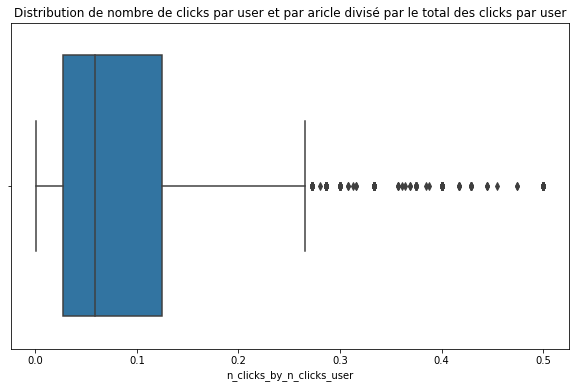

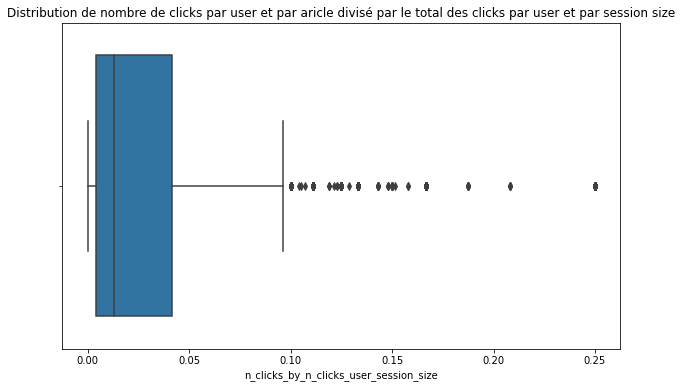

In [ ]:
var1 = 'n_clicks_by_session_size'
var2 = 'n_clicks_by_n_clicks_user'
var3 = 'n_clicks_by_n_clicks_user_session_size'
fig = plt.figure(figsize=(10,6))
sns.boxplot(data = merge_user_article, x = var1)
plt.title('Distribution de nombre de clicks par user et par aricle divisé par la taille de session')
fig.savefig(figure_path + var1 + '.png')
plt.show()

fig = plt.figure(figsize=(10,6))
sns.boxplot(data = merge_user_article, x = var2)
plt.title('Distribution de nombre de clicks par user et par aricle divisé par le total des clicks par user')
fig.savefig(figure_path + var2 + '.png')
plt.show()

fig = plt.figure(figsize=(10,6))
sns.boxplot(data = merge_user_article, x = var3)
plt.title('Distribution de nombre de clicks par user et par aricle divisé par le total des clicks par user et par session size')
fig.savefig(figure_path + var3 + '.png')
plt.show()

In [ ]:
merge_user_article.iloc[:,2:].describe()

,n_clicks_user_article,n_clicks_user,session_size_max,n_clicks_by_session_size,n_clicks_by_n_clicks_user,n_clicks_by_n_clicks_user_session_size
count,2.950710e+06,2.950710e+06,2.950710e+06,2.950710e+06,2.950710e+06,2.950710e+06
mean,1.012699e+00,3.264312e+01,5.812462e+00,2.572044e-01,1.094303e-01,4.105156e-02
std,1.344699e-01,5.677744e+01,5.800024e+00,1.383381e-01,1.295019e-01,6.516995e-02
min,1.000000e+00,2.000000e+00,2.000000e+00,8.064516e-03,8.116883e-04,8.588409e-06
25%,1.000000e+00,8.000000e+00,3.000000e+00,1.428571e-01,2.702703e-02,4.166667e-03
50%,1.000000e+00,1.700000e+01,4.000000e+00,2.500000e-01,5.882353e-02,1.315789e-02
75%,1.000000e+00,3.800000e+01,7.000000e+00,3.333333e-01,1.250000e-01,4.166667e-02
max,3.300000e+01,1.232000e+03,1.240000e+02,5.000000e+00,5.000000e-01,2.500000e-01


## 2. Mise en œuvre de filtrage basé sur le contenu

Le content-based filtering consiste à recommander des éléments similaires à ceux que l'utilisateur a déjà aimés dans le passé. Cette méthode se base sur les caractéristiques des éléments recommandés, telles que le genre ou le réalisateur d'un film, le style musical d'une chanson, etc. Le système évalue ensuite la similarité entre les caractéristiques de l'élément recommandé et celles des éléments que l'utilisateur a déjà aimés pour faire une recommandation.

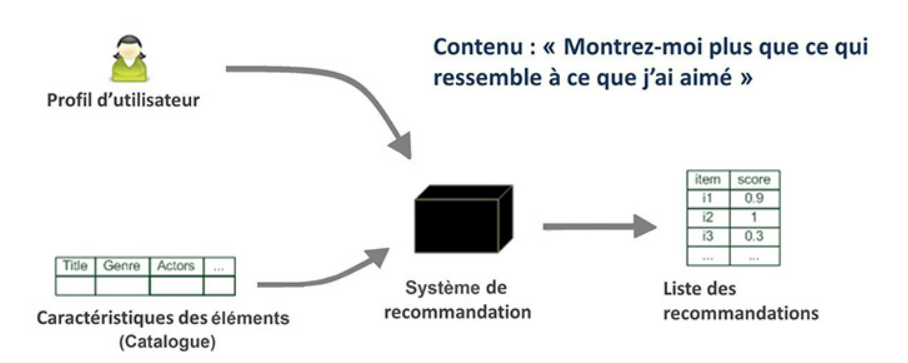

### Définition de la fonction de recommandation

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def content_based_filtering(user_preferences, embeddings_matrix = articles_embeddings, user_data = merge_user_article, n_recommendations = 5):

  # Définir les articles que le user a déja lu
  user_id_clicked_articles = user_data.filter(items = ['user_id', 'click_article_id']).query(f'user_id == {user_preferences}')

  # Choisir un article au hasard 
  user_choised_article_id = np.random.choice(user_id_clicked_articles['click_article_id'], size=1, replace=False)[0]

  # Calcul de la similarité cosinus entre les préférences de l'utilisateur et les embeddings des éléments
  user_embeddings_row = embeddings_matrix[user_choised_article_id, :].reshape(1,-1)
  new_embedding_matrix = np.delete(embeddings_matrix, user_choised_article_id, axis = 0)
  similarities = cosine_similarity(new_embedding_matrix, user_embeddings_row).reshape(1,-1)[0]

  # Récupération des indices des éléments les plus similaires
  sorted_similarities = np.sort(similarities)[::-1][:n_recommendations]
  top_indices = np.argsort(similarities)[::-1][:n_recommendations]
  recommandations_df = article_metadata.iloc[top_indices, :-1]

  # Affichage
  print("Recommending " + str(n_recommendations) + " products similar to " + str(user_choised_article_id) + "...")   
  print("-------")     
  for rec, similarity in zip(top_indices, sorted_similarities): 
      print("Recommended: " + str(rec) + " (cosinus similarity:" +      str(similarity) + ")")
    
  # Retourne les indices des éléments recommandés
  return top_indices


### Test de la fonction

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(user_id=widgets.IntSlider(min=0, max= 322_896, value = 160_000), n_recommend = fixed(5))

def get_cb_recommandations(user_id, n_recommend=5):
  top_indices = content_based_filtering(user_id, n_recommendations = n_recommend)
  recommandations_df = article_metadata.iloc[top_indices, :-1]

  return recommandations_df

interactive(children=(IntSlider(value=160000, description='user_id', max=322896), Output()), _dom_classes=('wi…

## 3. Mise en œuvre de filtrage collaboratif (SVD)

Le filtrage collaboratif, quant à lui, se base sur les préférences d'autres utilisateurs similaires pour recommander des éléments à un utilisateur. Cette méthode utilise les données de préférences d'un grand nombre d'utilisateurs pour trouver des similitudes entre leurs goûts et ceux de l'utilisateur pour qui une recommandation est faite. Les éléments recommandés sont ceux qui ont été appréciés par d'autres utilisateurs ayant des goûts similaires.

Le filtrage collaboratif est souvent utilisé lorsque les caractéristiques des éléments recommandés sont difficiles à déterminer, ou lorsque les données de préférences d'un utilisateur sont limitées. Le content-based filtering, en revanche, est plus approprié pour recommander des éléments très similaires à ceux que l'utilisateur a déjà aimés.

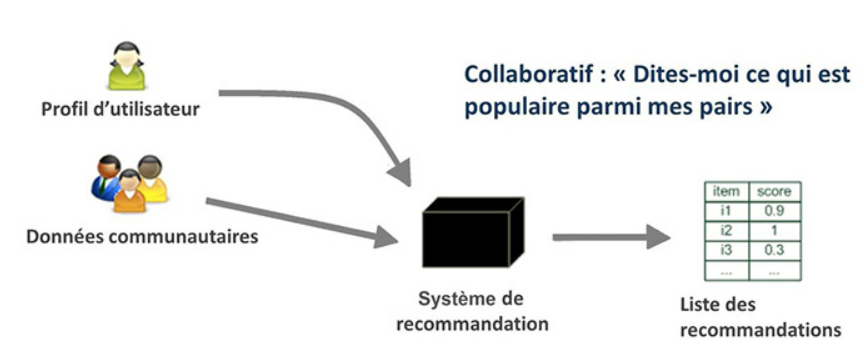

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366568 sha256=473c8083e76bf79e15996120e5f4f408097fccb8eabae0f64ba0f45bbd3ef881
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
merge_user_article.head()

,user_id,click_article_id,n_clicks_user_article,n_clicks_user,session_size_max,n_clicks_by_session_size,n_clicks_by_n_clicks_user,n_clicks_by_n_clicks_user_session_size
0,0,68866,1,8,2,0.5,0.125,0.0625
1,0,87205,1,8,2,0.5,0.125,0.0625
2,0,87224,1,8,2,0.5,0.125,0.0625
3,0,96755,1,8,2,0.5,0.125,0.0625
4,0,157541,1,8,2,0.5,0.125,0.0625


#### Premier enntraînement du modèle


In [ ]:
pd.options.display.float_format = '{:,.4f}'.format
merge_user_article['n_clicks_by_session_size'].describe()

count   2,950,710.0000
mean            0.2572
std             0.1383
min             0.0081
25%             0.1429
50%             0.2500
75%             0.3333
max             5.0000
Name: n_clicks_by_session_size, dtype: float64

In [ ]:
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import SVD, accuracy

data = merge_user_article
rating = 'n_clicks_by_session_size'

# Calcul le min et le max du rating
m = data[rating].min()
M = data[rating].max()

# Définir les colonnes du fichier de données
reader = Reader(rating_scale=(m,M))

# Chargement des données
data = Dataset.load_from_df(data[['user_id', 'click_article_id', rating]], reader)

# Diviion des données en données de l'entraînement et des données de test
trainset, testset = train_test_split(data, test_size=0.25)

# Définir de l'algorithme de recommandation à utiliser
based_algo = SVD(n_factors = 20, n_epochs=20, lr_all = 0.007, reg_all = 0.02)

# Entraînement de l'algorithme  sur l'ensemble d'entraînement
based_algo.fit(trainset)

# Faire des prédictions sur l'ensemble de test
predictions = based_algo.test(testset)

# Évaluer les performances du modèle
accuracy.rmse(predictions)
accuracy.mae(predictions)


RMSE: 0.1141
MAE:  0.0961


0.09611137669454936

In [ ]:
type(data)

surprise.dataset.DatasetAutoFolds

In [ ]:
real_rating = [predictions[i].r_ui for i in range(len(testset))]
predict_rating = [predictions[i].est for i in range(len(testset))]

In [ ]:
def plot_boxplots(real_rating, predict_rating, filename_save=None):

  # création de la figure et des boîtes à moustaches
  fig, ax = plt.subplots(figsize=(10, 7))
  ax.boxplot([real_rating, predict_rating], positions=[1, 2], widths=0.6)

  # changement des étiquettes d'axe
  ax.set_xticks([1, 2])
  ax.set_xticklabels(['Real rating', 'Predict rating'], fontsize=14)
  ax.set_title('Comparaison entre le rating réel et le rating prédit', fontsize=16, fontweight="bold")
  if filename_save:
    fig.savefig(filename_save)
  plt.show()

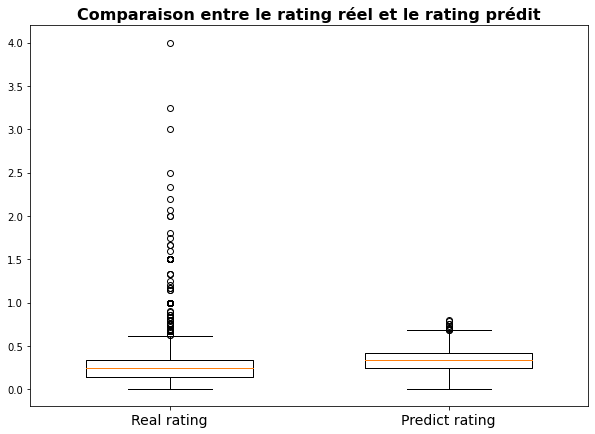

In [ ]:
filename_save = figure_path + 'boxplot_pred_based_model.png'
plot_boxplots(real_rating, predict_rating, filename_save)

#### Optimisation du modèle


In [ ]:
%%time

from surprise.model_selection import GridSearchCV
from surprise import SVD, accuracy

# Définir un dictionaire des paramètres
param_grid = {
 'n_factors' : [20,30,40], 
 'n_epochs' : [20,50,70,90], 
 'lr_all' : [0.007,0.006,0.005], 
 'reg_all' : [0.02,0.03,0.01]   
}

# Entraînement de gridsearchcv
gs = GridSearchCV(SVD, 
                  param_grid, 
                  measures = ["rmse", "mae"], 
                  cv = 3, 
                  joblib_verbose = 2,
                  n_jobs = -1)
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 22.4min


CPU times: user 23min 36s, sys: 1min 27s, total: 25min 3s
Wall time: 57min 42s


[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 57.3min finished


In [ ]:
# Le meilleur score obtenu par gridsearchcv
print('Meilleur score RMSE :', gs.best_score["rmse"])

# Choix des meilleur paramètres
print('Meilleur paramètre :', gs.best_params["rmse"])

Meilleur score RMSE : 0.07196789974516782
Meilleur paramètre : {'n_factors': 20, 'n_epochs': 90, 'lr_all': 0.007, 'reg_all': 0.01}


In [ ]:
%%time

# Définir de l'algorithme de recommendation à utiliser
params = gs.best_params["rmse"]
algo = SVD(n_factors = params['n_factors'], 
           n_epochs =  params['n_epochs'],  
           lr_all = params['lr_all'], 
           reg_all = params['reg_all'])

# Entraînement de l'algorithme  sur l'ensemble d'entraînement
algo.fit(trainset)

# Faire des prédictions sur l'ensemble de test
predictions = algo.test(testset)

# Évaluer les performances du modèle
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.0719
MAE:  0.0570
CPU times: user 1min 56s, sys: 340 ms, total: 1min 57s
Wall time: 1min 56s


0.05703569814634002

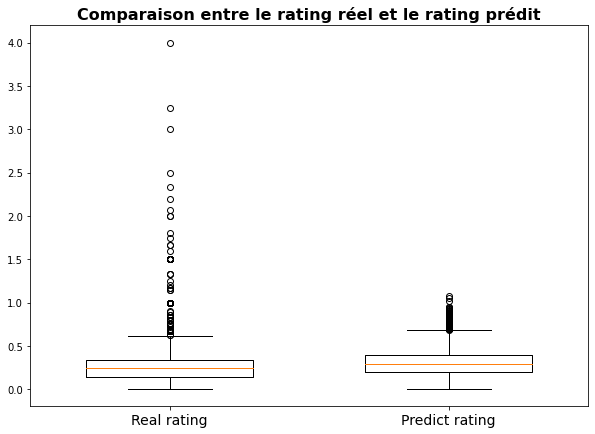

In [ ]:
# Visualisation des résultats de prédition
real_rating = [predictions[i].r_ui for i in range(len(testset))]
predict_rating = [predictions[i].est for i in range(len(testset))]

# Visualiser et enregistrer le graphe avec le nom 'boxplot_pred_opt_model.png'
filename_save = figure_path + 'boxplot_pred_opt_model.png'
plot_boxplots(real_rating, predict_rating, filename_save)

### Définition de la fonction de recommandation

In [ ]:
def collaborative_filtering(user_id, n_recommendations = 5, user_data = merge_user_article):

  # Définir les articles déjà lu par un user
  clicks_articles = merge_user_article.filter(items = ['user_id', 'click_article_id']).query(f'user_id == {user_id}')['click_article_id']
  
  # Definir les articles qui n'était pas déja vu
  not_clicks_articles = [article for article in range(364_047) if article not in clicks_articles]

  # Prédire le rating du user sur les articles qu'il n'a pas déjà vus
  for article_id in not_clicks_articles:

    pred = algo.predict(uid = user_id, iid = article_id, r_ui = n_recommendations, verbose=False)
    
  # Obtenir les recommandations
  recommendations = []

  for pred in predictions:
      recommendations.append((pred.iid, pred.est))

  recommendations.sort(key=lambda x: x[1], reverse=True)
  top_n_recommendations = recommendations[:n_recommendations]

  print(f"Top {n_recommendations} recommandations pour l'utilisateur", user_id, "\n")

  top_indices = []
  for iid, est in top_n_recommendations:
    print("Article", iid, "- rating prédit:", round(est, 2))

    top_indices.append(iid)

  return top_indices


### Test de la fonction

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(user_id=widgets.IntSlider(min=0, max= 322_896, value = 160_000), n_recommend = fixed(5))

def get_cb_recommandations(user_id, n_recommend=5):
  top_indices = collaborative_filtering(user_id, n_recommendations = n_recommend)
  recommandations_df = article_metadata.iloc[top_indices, :-1]

  return recommandations_df

interactive(children=(IntSlider(value=160000, description='user_id', max=322896), Output()), _dom_classes=('wi…